In [2]:
%reset -f
import tensorflow as tf
import numpy as np

np.random.seed(7) # for reproducibility

import os
import sys
import string
import re
import collections
from sklearn.model_selection import StratifiedKFold

from keras.initializers import TruncatedNormal
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
available_datasets = {"rosetta": {"path": "./datasets/rosetta", "compress_file": "rosetta.npz"},
           "github": {"path": "./datasets/github", "compress_file": "github.npz"}, 
           "lang": {"path": "./datasets/lang", "compress_file": "lang.npz"}, }

current_dataset = 'lang'

## Prepare data

In [19]:
dataset_path = available_datasets[current_dataset]["path"]
compress_file = available_datasets[current_dataset]["compress_file"]

def tokenize(text):
    tokens = re.split('(\W+)', text)
    tokens = filter(lambda x: x != '' and x != ' ', tokens)
    tokens = map(lambda token: token.strip().split() if not token.isdigit() else ['<NUM>'], tokens)
    tokens = list(tokens)
    if len(tokens) == 0:
        return []
    return np.hstack(tokens)

def process_data(dataset_path, dictionary_size=None):
    
    # Get language list
    languages = list(filter(lambda d: os.path.isdir(dataset_path + '/' + d), os.listdir(dataset_path)))
    examples = []
    labels = []
    filenames = []
    dictionary = dict()

    # Load data
    
    count = [['<EOF>', -1], ['<UNK>', -1]]
    counter = collections.Counter()
    
    for language_index, language in enumerate(languages):
        files = os.listdir(dataset_path + '/' + language)
        for filename in files:
            try:
                with open(dataset_path + '/' + language + '/' + filename, mode="r") as file:
                    content = tokenize("".join(file.readlines()))
                counter.update(content)
            except:
                # Ignore files with encoding problems (TODO: handle different encodings)
                pass

    
    count.extend(counter.most_common(dictionary_size -2))
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    
    for language_index, language in enumerate(languages):
        files = os.listdir(dataset_path + '/' + language)
        for filename in files:
            try:
                with open(dataset_path + '/' + language + '/' + filename, mode="r") as file:
                    content = tokenize("".join(file.readlines()))
                    content = np.array(list(map(lambda word: dictionary[word] if word in dictionary else dictionary['<UNK>'], content)))
            except:
                # Ignore files with encoding problems (TODO: handle different encodings)
                content = []
                
            if len(content) < 1:
                print("Ignoring file " + filename)
            else:
                examples.append(content)
                labels.append(language_index)
                filenames.append(filename)

        
    reverse_dictionary = list(map(lambda x: x[0], count))
    
    np.savez_compressed(compress_file, X=np.array(examples), Y=np.array(labels), filenames=np.array(filenames),
                       dictionary=dictionary, reverse_dictionary=np.array(reverse_dictionary),
                       languages=np.array(languages))
    
if not os.path.isfile(compress_file):
    process_data(dataset_path, dictionary_size=10000)

Ignoring file foo.rb
Ignoring file mixin.rb
Ignoring file plugin_controller.rb
Ignoring file user_controller.rb
Ignoring file %base_name%_test.rb
Ignoring file access_test.tpl.php
Ignoring file BlobUtilities.cs
Ignoring file Resources.cs
Ignoring file ltc2952-poweroff.c
Ignoring file sha256_neon_glue.c
Ignoring file ebcdic.c
Ignoring file font_7x14.c
Ignoring file font_8x8.c
Ignoring file ni_mio_c_common.c
Ignoring file font_8x16.c
Ignoring file rtl8723a_bt-coexist.c
Ignoring file font_pearl_8x8.c
Ignoring file test_models.py
Ignoring file file.py
Ignoring file empty.py
Ignoring file no_urls.py
Ignoring file __init__.py
Ignoring file formats.py
Ignoring file haddockA011.hs
Ignoring file utf8_003.hs
Ignoring file OtherModule.hs
Ignoring file haddockC011.hs
Ignoring file haddockA004.hs
Ignoring file utf8_010.hs
Ignoring file LrcPrelude.hs
Ignoring file utf8_002.hs
Ignoring file Funcs_Lexer.hs
Ignoring file haddockE003.hs
Ignoring file utf8_022.hs
Ignoring file utf8_005.hs
Ignoring file h

In [20]:
dataset = np.load(compress_file)

In [21]:
dataset.files

['X', 'Y', 'filenames', 'dictionary', 'reverse_dictionary', 'languages']

In [22]:
X = dataset['X']
Y = dataset['Y']
dictionary = dataset['dictionary'].item(0)
languages = dataset['languages']
print(X.shape)
print(Y.shape)
print(len(dictionary))
print(len(languages))

(61398,)
(61398,)
10000
10


In [23]:
def memento(embeddings_size, sequence_length, dropout, num_clases, learning_rate, dictionary_size=10000):
    
    model = Sequential()
    
    initializer = TruncatedNormal(mean=0.0, stddev=1.0)
    
    model.add((Embedding(input_dim=dictionary_size, output_dim=embeddings_size,
                                   embeddings_initializer=initializer,
                                   mask_zero=True, trainable=False,
                                   input_length=sequence_length,
                                   batch_input_shape=(None, sequence_length))))
    
    model.add(LSTM(embeddings_size, input_shape=(None, sequence_length, embeddings_size), dropout=dropout, 
                   return_sequences=False, stateful=False,
                   recurrent_activation='sigmoid', activation='tanh', implementation=2))
    
    model.add(Dense(num_clases, activation='softmax'))
    
    adam = Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model
    

In [24]:
batch_size = 256
sequence_length = 30
learning_rate = 0.001
dropout = 0.5
embeddings_size = 32
epochs = 50

tf.reset_default_graph()
    
with tf.Session() as sess:    
    k_fold = StratifiedKFold(n_splits=10, shuffle=True)
    train, test = list(k_fold.split(X, Y))[0]

    model = memento(embeddings_size=embeddings_size, sequence_length=sequence_length, 
                    dropout=dropout, num_clases=len(languages), learning_rate=learning_rate)

    y_train_one_hot = to_categorical(Y[train], num_classes=len(languages))
    x_train_padded = pad_sequences(X[train], maxlen=sequence_length)
    y_test_one_hot = to_categorical(Y[test], num_classes=len(languages))
    x_test_padded = pad_sequences(X[test], maxlen=sequence_length)


    history = model.fit(x_train_padded, y_train_one_hot, batch_size=batch_size, epochs=epochs, 
                      validation_data=(x_test_padded, y_test_one_hot), shuffle=True)

Train on 55253 samples, validate on 6145 samples
Epoch 1/50
55253/55253 [==============================] - 9s - loss: 1.4778 - acc: 0.5227 - val_loss: 0.8313 - val_acc: 0.7367
Epoch 2/50
55253/55253 [==============================] - 10s - loss: 0.8857 - acc: 0.7178 - val_loss: 0.6897 - val_acc: 0.7745
Epoch 3/50
55253/55253 [==============================] - 8s - loss: 0.7332 - acc: 0.7637 - val_loss: 0.5994 - val_acc: 0.8041
Epoch 4/50
55253/55253 [==============================] - 8s - loss: 0.6563 - acc: 0.7874 - val_loss: 0.5062 - val_acc: 0.8384
Epoch 5/50
55253/55253 [==============================] - 8s - loss: 0.6063 - acc: 0.8037 - val_loss: 0.4798 - val_acc: 0.8446
Epoch 6/50
55253/55253 [==============================] - 9s - loss: 0.5657 - acc: 0.8158 - val_loss: 0.4404 - val_acc: 0.8641
Epoch 7/50
55253/55253 [==============================] - 8s - loss: 0.5405 - acc: 0.8253 - val_loss: 0.4196 - val_acc: 0.8744
Epoch 8/50
55253/55253 [==============================] - 11s

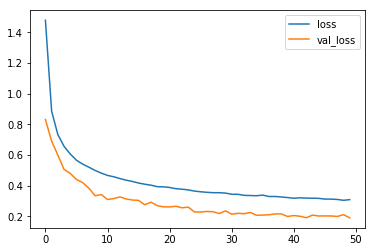

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

time = range(history.params['epochs'])

loss, = plt.plot(time, history.history['loss'], label='loss')
val_loss, = plt.plot(time, history.history['val_loss'], label='val_loss')

plt.legend(handles=[loss, val_loss])


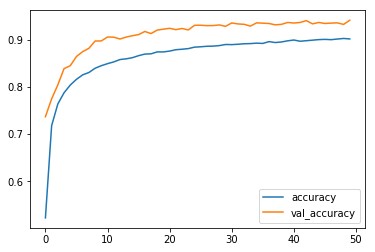

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

time = range(history.params['epochs'])

loss, = plt.plot(time, history.history['acc'], label='accuracy')
val_loss, = plt.plot(time, history.history['val_acc'], label='val_accuracy')

plt.legend(handles=[loss, val_loss])
